### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality",
        "desafioadventureworks-446600.stg_marts_tables.fact_product_forecast",
        "desafioadventureworks-446600.stg_marts_tables.fact_sales"
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.stg_marts_tables"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality', 'desafioadventureworks-446600.stg_marts_tables.fact_product_forecast', 'desafioadventureworks-446600.stg_marts_tables.fact_sales']


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [3]:
# Setup inicial do df 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [4]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality
Lendo os dados do BigQuery...
Tabela fact_product_seasonality processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_marts_tables.fact_product_forecast
Lendo os dados do BigQuery...
Tabela fact_product_forecast processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_marts_tables.fact_sales
Lendo os dados do BigQuery...
Tabela fact_sales processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [5]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: fact_product_seasonality
Variável criada: fact_product_forecast
Variável criada: fact_sales


In [6]:
# Consolidando os dados para previsão
fact_product_seasonality = df_processados['fact_product_seasonality']
fact_product_forecast = df_processados['fact_product_forecast']
fact_sales = df_processados['fact_sales']

In [7]:
print(fact_product_seasonality.head())


print(fact_product_forecast.head())


print(fact_sales.head())

   productid_id  total_quantity_sold year_month  year  month
0           712                   40    2011-05  2011      5
1           712                  103    2011-07  2011      7
2           712                  137    2011-08  2011      8
3           712                  240    2011-10  2011     10
4           712                   25    2011-12  2011     12
   store_id  productid_id forecast_date  forecast_quantity  avg_unit_price  forecast_sales_value
0         6           776    2025-04-26             400.00         2415.54             966214.44
1         3           869    2025-03-26            1256.00           52.87              66400.01
2        10           980    2025-04-26             124.00          622.68              77212.01
3         7           980    2025-04-26             100.00          622.68              62267.75
4         5           709    2025-01-26            1056.00            5.66               5974.22
   salesorderid_id_soh  customerid_id  creditcardid_

In [8]:
# df filtrado
forecast_data = fact_product_forecast[['store_id', 'productid_id', 'forecast_date', 'forecast_quantity']]

print(forecast_data.head())


   store_id  productid_id forecast_date  forecast_quantity
0         6           776    2025-04-26             400.00
1         3           869    2025-03-26            1256.00
2        10           980    2025-04-26             124.00
3         7           980    2025-04-26             100.00
4         5           709    2025-01-26            1056.00


## Questão 8 - Previsão de demanda e sazonalidade

In [9]:
# Dados agrupados por lojaspara calcular a demanda total prevista | TOP 10 LOJAS
forecast_summary = forecast_data.groupby('store_id').agg(
    total_forecast_quantity=('forecast_quantity', 'sum')
).reset_index()

print(forecast_summary)

   store_id  total_forecast_quantity
0         1               9948192.00
1         2               5011984.00
2         3               4870256.00
3         4              17850928.00
4         5               4868928.00
5         6              14796192.00
6         7               4623568.00
7         8               2676224.00
8         9               4058496.00
9        10               5013312.00


C:\Users\wrpen\AppData\Local\Temp\ipykernel_78872\3367433632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=forecast_summary, x='store_id', y='total_forecast_quantity', palette='viridis')


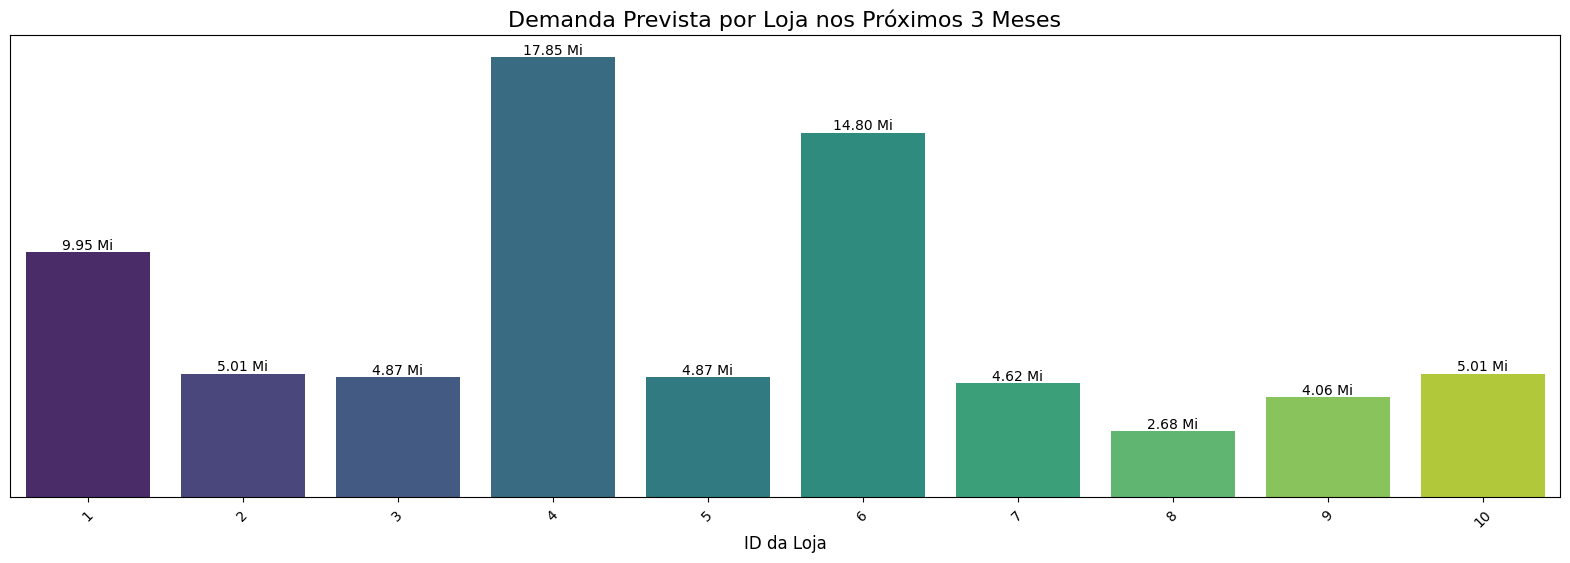

In [10]:
# Gráfico
plt.figure(figsize=(20, 6))
sns.barplot(data=forecast_summary, x='store_id', y='total_forecast_quantity', palette='viridis')

for index, row in forecast_summary.iterrows():
    plt.text(index, row['total_forecast_quantity'], f"{row['total_forecast_quantity'] / 1e6:.2f} Mi", 
             ha='center', va='bottom', fontsize=10)


plt.title("Demanda Prevista por Loja nos Próximos 3 Meses", fontsize=16)
plt.xlabel("ID da Loja", fontsize=12)
plt.ylabel("") 
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

## Sazonalidade

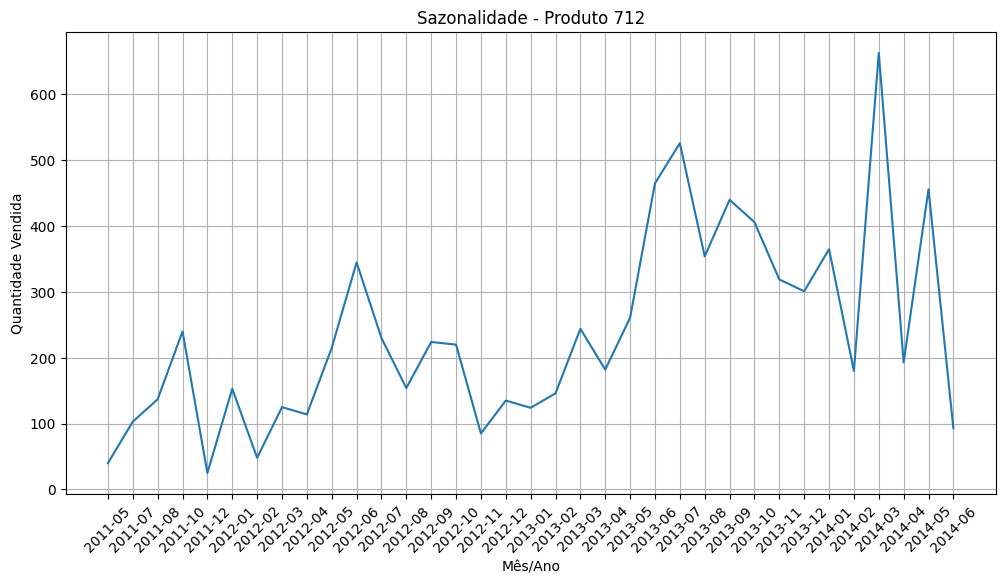

In [11]:
# Produto 712 na tabela de sazonalidade*
produto_712 = fact_product_seasonality[fact_product_seasonality['productid_id'] == 712]

plt.figure(figsize=(12, 6))
sns.lineplot(data=produto_712, x="year_month", y="total_quantity_sold")
plt.title("Sazonalidade - Produto 712")
plt.xlabel("Mês/Ano")
plt.ylabel("Quantidade Vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#doc*: AWC Logo Cap = boné com o logotipo da "Adventure Works Cycles" (AWC)

In [12]:
#doc:sazonalidade por mês/ano
#    - gráfico mostra um comportamento sazonal com picos regulares em meses específicos,como junho (2012-06, 2013-06) e fevereiro (2014-02)
#    - demanda do produto 712 varia ao longo dos anos, mas mantém uma tendência de alta nos meses de junho e fevereiro
#    - há vales regulares em meses como novembro (2013-11) e junho (2014-06), indicando períodos de baixa demanda

C:\Users\wrpen\AppData\Local\Temp\ipykernel_78872\3929377954.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sazonalidade_por_mes, x='month', y='total_quantity_sold', palette='viridis')


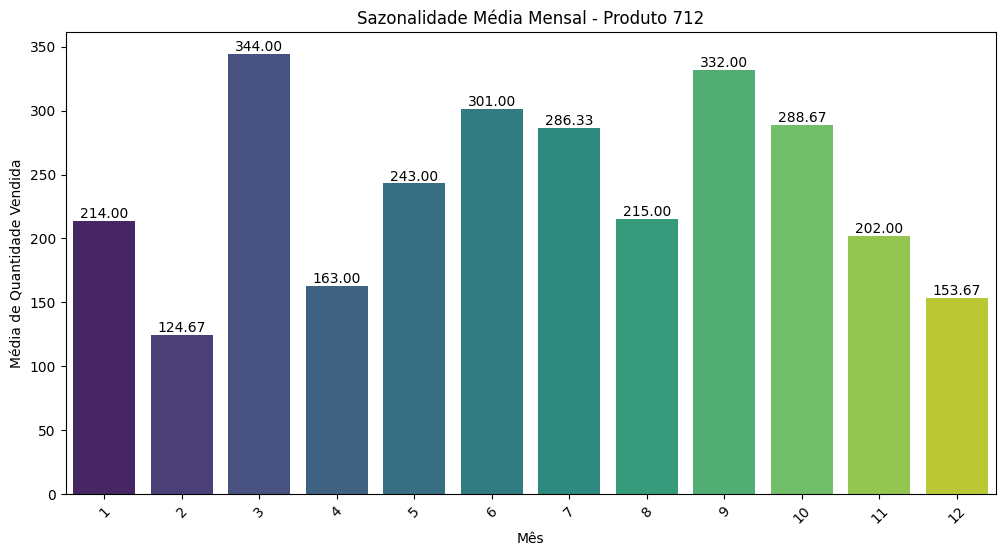

In [13]:
# Agrupar por mês para calcular a média de vendas
produto_712['month'] = pd.to_datetime(produto_712['year_month']).dt.month
sazonalidade_por_mes = produto_712.groupby('month')['total_quantity_sold'].mean().reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=sazonalidade_por_mes, x='month', y='total_quantity_sold', palette='viridis')

for index, row in sazonalidade_por_mes.iterrows():
    plt.text(index, row['total_quantity_sold'], f"{row['total_quantity_sold']:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Sazonalidade Média Mensal - Produto 712")
plt.xlabel("Mês")
plt.ylabel("Média de Quantidade Vendida")
plt.xticks(rotation=45)
plt.show()


In [14]:
#doc:sazonalidade média mensal
#    - média de vendas mensal indica que os meses de março (344) e setembro (332) são os de maior demanda para o produto 712
#    - os meses de fevereiro (124,67) e dezembro (153,67) possuem as menores médias, indicando baixa sazonalidade nesses períodos
#    - estratégias:
#       - Alta demanda: focar em campanhas de marketing e aumento de estoque em março, junho e setembro
#       - Baixa demanda: explorar promoções ou incentivos para aumentar as vendas em fevereiro e dezembro

## Questão 9

<!-- 
Para resolver a Questão 9, vamos usar uma abordagem com modelos de regressão para prever a demanda e justificar o modelo com base em métricas de avaliação. Aqui está como estruturaremos a resposta:

Passo 1: Configurar os dados para regressão
Os dados que você já tem (ex: fact_product_seasonality) serão usados para:

Definir as variáveis dependentes (target): total_quantity_sold (demanda).
Definir as variáveis independentes (features): month, year, e outras variáveis que podem influenciar as vendas. -->

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparando os dados
produto_712['year'] = pd.to_datetime(produto_712['year_month']).dt.year
X = produto_712[['year', 'month']]  # variáveis independentes
y = produto_712['total_quantity_sold']  # variável dependente (target)

# Treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Regressão linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Previsões
y_pred_linear = linear_model.predict(X_test)

# Avaliação do modelo
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Regressão Linear - MAE: {mae_linear:.2f}, MSE: {mse_linear:.2f}, R2: {r2_linear:.2f}")


Regressão Linear - MAE: 51.61, MSE: 5404.83, R2: 0.47


In [17]:
from sklearn.ensemble import RandomForestRegressor

# Modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliação do modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}")


Random Forest - MAE: 104.24, MSE: 13967.56, R2: -0.37


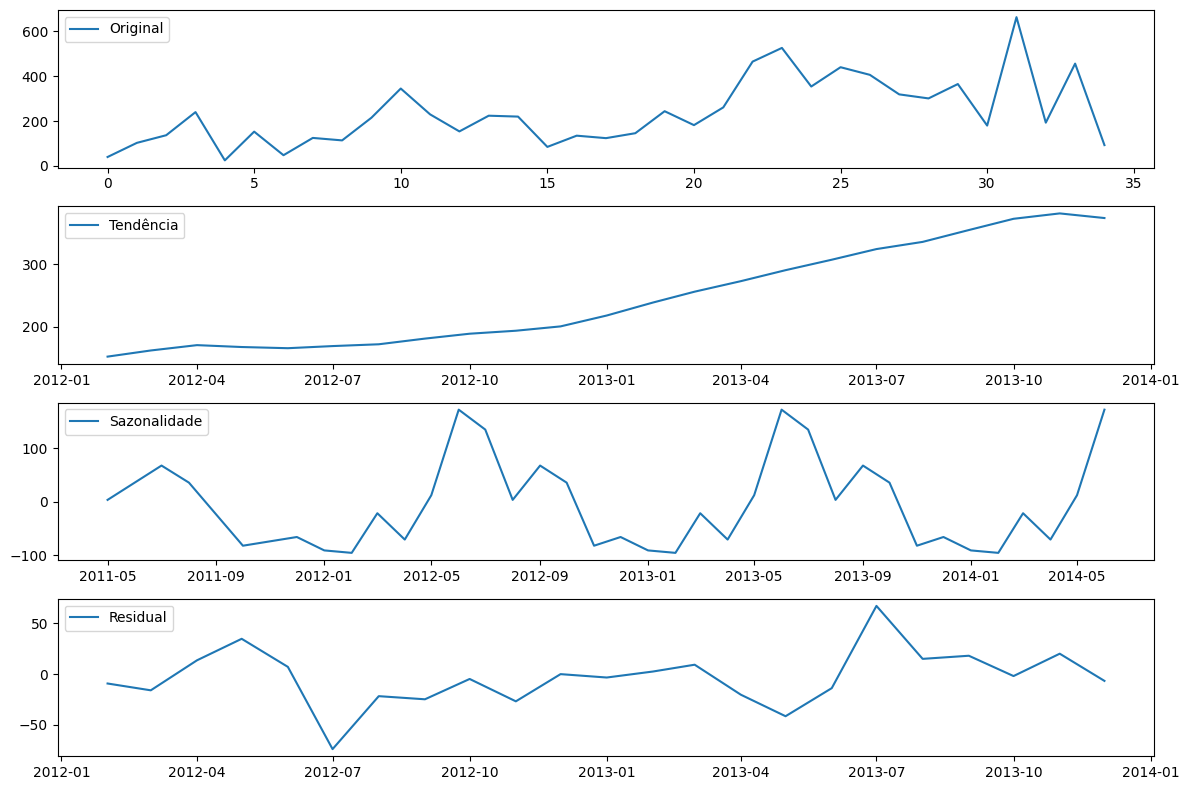

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Supondo que o seu DataFrame se chame produto_712
# Convertendo 'year_month' para datetime
produto_712['year_month'] = pd.to_datetime(produto_712['year_month'], format='%Y-%m')

# Decomposição sazonal
result = seasonal_decompose(produto_712.set_index('year_month')['total_quantity_sold'], model='additive', period=12)

# Função para plotar os componentes da decomposição sazonal
def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['total_quantity_sold'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

# Gerando os gráficos
seasonal_decomposition_plots(data=produto_712, seasonal_decomposition=result)


In [19]:
produto_712.head()

,productid_id,total_quantity_sold,year_month,year,month
0,712,40,2011-05-01,2011,5
1,712,103,2011-07-01,2011,7
2,712,137,2011-08-01,2011,8
3,712,240,2011-10-01,2011,10
4,712,25,2011-12-01,2011,12


In [20]:
# Garantindo que a coluna 'total_quantity_sold' seja numérica
produto_712['total_quantity_sold'] = pd.to_numeric(produto_712['total_quantity_sold'], errors='coerce')


In [21]:
# Verificando se existem valores nulos após a conversão 
if produto_712['total_quantity_sold'].isnull().sum() > 0:
    print(f"Há {produto_712['total_quantity_sold'].isnull().sum()} valores nulos na coluna 'total_quantity_sold'.")
    # Substituindo valores nulos pela média
    produto_712['total_quantity_sold'].fillna(produto_712['total_quantity_sold'].mean(), inplace=True)


In [22]:
# Garantir que 'total_quantity_sold' seja numérico, forçando a conversão
produto_712['total_quantity_sold'] = pd.to_numeric(produto_712['total_quantity_sold'], errors='coerce')

# Verificando se há valores nulos após a conversão
if produto_712['total_quantity_sold'].isnull().sum() > 0:
    print(f"Há {produto_712['total_quantity_sold'].isnull().sum()} valores nulos na coluna 'total_quantity_sold'.")
    # Substituindo valores nulos pela média ou pela mediana
    produto_712['total_quantity_sold'].fillna(produto_712['total_quantity_sold'].mean(), inplace=True)

# Verificando novamente o tipo dos dados
print(produto_712['total_quantity_sold'].dtype)


Int64


In [23]:
print(produto_712['year_month'].head())


0   2011-05-01
1   2011-07-01
2   2011-08-01
3   2011-10-01
4   2011-12-01
Name: year_month, dtype: datetime64[ns]


In [24]:
produto_712['year_month'] = pd.to_datetime(produto_712['year_month'], format='%Y-%m', errors='coerce')


In [25]:
# Convertendo para int64 explicitamente
produto_712['total_quantity_sold'] = produto_712['total_quantity_sold'].astype('int64')

# Caso queira usar float64, pode ser útil quando lidar com valores com decimais
# produto_712['total_quantity_sold'] = produto_712['total_quantity_sold'].astype('float64')


In [26]:
# Criar a coluna 'year_month' combinando 'year' e 'month'
produto_712['year_month'] = pd.to_datetime(produto_712[['year', 'month']].assign(day=1))

# Verificar se a coluna foi criada corretamente
print(produto_712.head())

# Definir a coluna 'year_month' como índice
produto_712.set_index('year_month', inplace=True)

# Verificar o DataFrame e o tipo do índice após a conversão
print(produto_712.head())
print(produto_712.index.dtype)

   productid_id  total_quantity_sold year_month  year  month
0           712                   40 2011-05-01  2011      5
1           712                  103 2011-07-01  2011      7
2           712                  137 2011-08-01  2011      8
3           712                  240 2011-10-01  2011     10
4           712                   25 2011-12-01  2011     12
            productid_id  total_quantity_sold  year  month
year_month                                                
2011-05-01           712                   40  2011      5
2011-07-01           712                  103  2011      7
2011-08-01           712                  137  2011      8
2011-10-01           712                  240  2011     10
2011-12-01           712                   25  2011     12
datetime64[ns]


c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Previsões para os próximos 3 meses:
2014-06-30   408.48
2014-07-31   305.16
2014-08-31   375.97
Freq: M, dtype: float64
MAE do modelo SARIMA: 216.43
R² do modelo SARIMA: -1.12


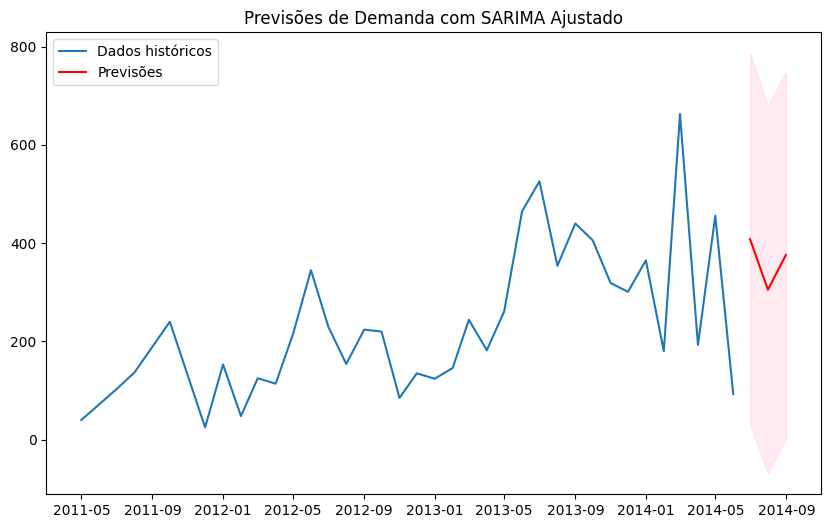

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Garantir que a coluna 'total_quantity_sold' está limpa e convertida para o tipo correto
produto_712['total_quantity_sold'] = produto_712['total_quantity_sold'].astype('int64')

# Preencher valores nulos, se necessário
produto_712['total_quantity_sold'].fillna(produto_712['total_quantity_sold'].mean(), inplace=True)

# Ajustando os parâmetros sazonais e de diferenciação
modelo_sarima = SARIMAX(produto_712['total_quantity_sold'].values, 
                        order=(1, 0, 1),   # (p, d, q) - parâmetros não sazonais
                        seasonal_order=(1, 1, 1, 12),  # (P, D, Q, m) - parâmetros sazonais, m=12 para dados mensais
                        enforce_stationarity=False,  
                        enforce_invertibility=False)

# Treinando o modelo
modelo_sarima_fitted = modelo_sarima.fit(disp=True)

# Fazendo previsões para os próximos 3 meses
forecast = modelo_sarima_fitted.get_forecast(steps=3)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Gerando o índice para as previsões corretamente com base na última data da série histórica
forecast_index = pd.date_range(start=produto_712.index[-1] + pd.DateOffset(1), periods=3, freq='M')

# Convertendo a previsão para uma série com o novo índice
forecast_mean_series = pd.Series(forecast_mean, index=forecast_index)

# Exibindo as previsões
print("Previsões para os próximos 3 meses:")
print(forecast_mean_series)

# Caso y_true_sarima seja necessário, garanta que está corretamente definido:
# Exemplo para os últimos 3 valores reais:
y_true_sarima = produto_712['total_quantity_sold'][-3:]

# Cálculo do MAE e R²
mae_sarima = mean_absolute_error(y_true_sarima, forecast_mean_series)
r2_sarima = r2_score(y_true_sarima, forecast_mean_series)

# Exibindo as métricas
print(f"MAE do modelo SARIMA: {mae_sarima:.2f}")
print(f"R² do modelo SARIMA: {r2_sarima:.2f}")

# Plotando a previsão junto com os dados originais
plt.figure(figsize=(10, 6))
plt.plot(produto_712.index, produto_712['total_quantity_sold'], label='Dados históricos')
plt.plot(forecast_mean_series.index, forecast_mean_series, label='Previsões', color='red')

# Ajustando a forma de acessar os intervalos de confiança (CI)
plt.fill_between(forecast_mean_series.index, 
                 forecast_ci[:, 0], forecast_ci[:, 1], 
                 color='pink', alpha=0.3)

plt.legend()
plt.title('Previsões de Demanda com SARIMA Ajustado')
plt.show()


In [29]:
# Regressão Linear:
# A Regressão Linear apresentou melhores resultados com MAE menor (51.61) e R² positivo (0.47), mostrando que é capaz de explicar 47% da variação na demanda. 
# Esse modelo foi eficaz para capturar relações lineares nos dados, sendo a melhor opção quando comparado aos modelos mais complexos.

# Random Forest:
# O modelo Random Forest teve desempenho significativamente pior, com MAE mais alto (104.24) e R² negativo (-0.37), indicando que o modelo não conseguiu capturar os padrões 
# adequados na demanda. A natureza não-linear do Random Forest parece não ser adequada para esse problema específico, provavelmente devido à falta de variáveis explicativas 
# adicionais ou à dificuldade de capturar sazonalidade.

# SARIMA:
# O modelo SARIMA gerou previsões mais razoáveis, com MAE de 216.43 e R² de -1.12. O modelo foi capaz de capturar parcialmente as tendências sazonais e mensais dos dados, 
# mas ainda apresenta espaço para melhorias, principalmente com relação ao R² negativo, o que sugere que a explicação da variação dos dados não é ótima.